# Import

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install scikit-plot

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split as tts
np.random.seed(42)
random.seed(42)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Приведем датасеты к удобному виду

Разбиение слов на слоги

In [4]:
file1 = open("/content/train_stresses_labels.txt", "r")

labels = []
X = []
while True:
    line = file1.readline()
    if not line:
        break
    new_word = list(line.rstrip('\n'))
    arr_x = []
    for i in range(len(new_word)):
      if '^' in new_word[i]:
        labels.append(i-1)
        #arr_x.append(new_word[i].replace('^',''))
      else:
        arr_x.append(new_word[i])
    X.append(' '.join(arr_x))
file1.close

<function TextIOWrapper.close()>

In [5]:
d = {'word':X, 'label':labels}
data = pd.DataFrame(d)
data

,word,label
0,а а к,1
1,а а к а,1
2,а а к е,1
3,а а к и,1
4,а а к о в,1
...,...,...
588485,ё ф и к а т о р е,4
588486,ё ф и к а ц и и,4
588487,ё ф и к а ц и ю,4
588488,ё ф и к а ц и я,4


In [6]:
file1 = open("/content/public_test_stresses.txt", "r")

labels = []
X = []
while True:
    line = file1.readline()
    if not line:
        break
    new_word = list(line.rstrip('\n'))
    arr_x = []
    for i in range(len(new_word)):
        arr_x.append(new_word[i])
    X.append(' '.join(arr_x))
file1.close

<function TextIOWrapper.close()>

In [7]:
d = {'word':X}

In [8]:
data_test = pd.DataFrame(d)
data_test

,word
0,а а к а м
1,а а к а м и
2,а а л е н е ц
3,а а м а
4,а а м а м и
...,...
294248,ё м и у р и
294249,ё ф и к а т о р а м и
294250,ё ф и к а т о р у
294251,ё ф и к а ц и я м и


#EDA

In [9]:
data

,word,label
0,а а к,1
1,а а к а,1
2,а а к е,1
3,а а к и,1
4,а а к о в,1
...,...,...
588485,ё ф и к а т о р е,4
588486,ё ф и к а ц и и,4
588487,ё ф и к а ц и ю,4
588488,ё ф и к а ц и я,4


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588490 entries, 0 to 588489
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   word    588490 non-null  object
 1   label   588490 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.0+ MB


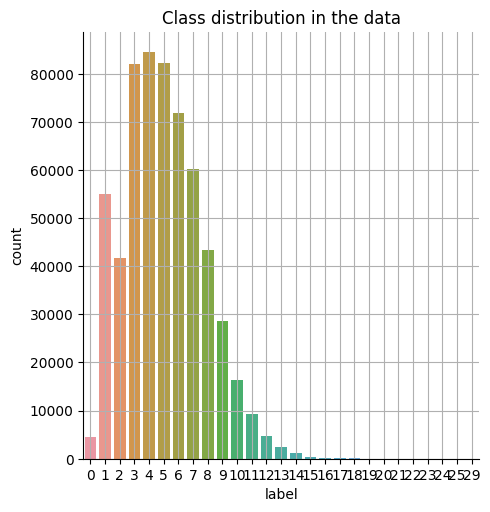

In [11]:
g = sns.catplot(x="label",
                kind="count",
                data=data.sort_values("label"))
plt.grid()
plt.title("Class distribution in the data");

In [12]:
data['label'].value_counts()

4     84462
5     82288
3     81972
6     71790
7     60136
1     54963
8     43322
2     41759
9     28570
10    16411
11     9200
12     4749
0      4420
13     2480
14     1103
15      450
16      193
17       91
18       52
19       36
20       14
22       12
23        5
21        4
29        4
24        3
25        1
Name: label, dtype: int64

In [13]:
data  = data[data['label'].isin([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])]
data

,word,label
0,а а к,1
1,а а к а,1
2,а а к е,1
3,а а к и,1
4,а а к о в,1
...,...,...
588485,ё ф и к а т о р е,4
588486,ё ф и к а ц и и,4
588487,ё ф и к а ц и ю,4
588488,ё ф и к а ц и я,4


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 588075 entries, 0 to 588489
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   word    588075 non-null  object
 1   label   588075 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.5+ MB


# Models

## RNN

In [15]:
train_dataset_pd, val_dataset_pd = np.split(data, [int(.8*len(data))])

In [16]:
len(train_dataset_pd['label'].value_counts())

16

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_dataset_pd['word'].values, train_dataset_pd['label'].values))
val_dataset = tf.data.Dataset.from_tensor_slices((val_dataset_pd['word'].values, val_dataset_pd['label'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((data_test['word'].values))


batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [18]:
example, label = next(iter(train_dataset))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])

Text:
 b'\xd0\xb0 \xd0\xb0 \xd0\xba'

Label:  1


In [19]:
encoder = tf.keras.layers.TextVectorization(max_tokens=100) # 100
encoder.adapt(train_dataset.map(lambda word, _: word))


vocabulary = np.array(encoder.get_vocabulary())


original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])

print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)

original:  b'\xd0\xb0 \xd0\xb0 \xd0\xba'
encoded:  [ 3  3 14]
decoded:  а а к


In [20]:
# Creating the model
model = tf.keras.Sequential([

	encoder,

	tf.keras.layers.Embedding(
		len(encoder.get_vocabulary()), 256, mask_zero=True),

	tf.keras.layers.BatchNormalization(),

	tf.keras.layers.Bidirectional(
		tf.keras.layers.LSTM(128, return_sequences=True)),

	tf.keras.layers.Dropout(0.2),

	tf.keras.layers.Bidirectional(
		tf.keras.layers.LSTM(64, return_sequences=True)),

  #tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Bidirectional(
		tf.keras.layers.LSTM(64, return_sequences=True)),

  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Bidirectional(
		tf.keras.layers.LSTM(64, return_sequences=True)),

  #tf.keras.layers.Dropout(0.2),

   tf.keras.layers.Bidirectional(
		tf.keras.layers.LSTM(64, return_sequences=False)),

	#tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Dropout(0.2),

	tf.keras.layers.Dense(64, activation='relu'),

  tf.keras.layers.Dense(32, activation='relu'),

  tf.keras.layers.Dropout(0.1),

	tf.keras.layers.Dense(16, activation='softmax')
])

model.summary()

model.compile(
	loss=tf.keras.losses.SparseCategoricalCrossentropy(), #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
	optimizer = tf.keras.optimizers.Adam(),
	metrics=['accuracy']
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 256)         8960      
                                                                 
 batch_normalization (Batch  (None, None, 256)         1024      
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, None, 256)         394240    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                        

In [21]:
ACCELERATOR_TYPE = 'GPU'

In [22]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[callback],
)

Epoch 1/20
14702/14702 [==============================] - 921s 59ms/step - loss: 1.3992 - accuracy: 0.5276 - val_loss: 1.3266 - val_accuracy: 0.6831
Epoch 2/20
14702/14702 [==============================] - 829s 56ms/step - loss: 0.6141 - accuracy: 0.8003 - val_loss: 0.7297 - val_accuracy: 0.7757
Epoch 3/20
14702/14702 [==============================] - 857s 58ms/step - loss: 0.4636 - accuracy: 0.8382 - val_loss: 0.8617 - val_accuracy: 0.7696
Epoch 4/20
14702/14702 [==============================] - 821s 56ms/step - loss: 0.3889 - accuracy: 0.8612 - val_loss: 0.7282 - val_accuracy: 0.7952
Epoch 5/20
14702/14702 [==============================] - 843s 57ms/step - loss: 0.3408 - accuracy: 0.8784 - val_loss: 0.4985 - val_accuracy: 0.8335
Epoch 6/20
14702/14702 [==============================] - 821s 56ms/step - loss: 0.3063 - accuracy: 0.8905 - val_loss: 0.5005 - val_accuracy: 0.8405
Epoch 7/20
14702/14702 [==============================] - 821s 56ms/step - loss: 0.2776 - accuracy: 0.8996

In [ ]:
# Training history
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

In [ ]:
model.save("/content/drive/MyDrive/my_model_20_new_bn.keras")

# Проверка работоспособности модели

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/my_model_20_new_bn.keras')

In [ ]:
def pred(pred, sample_text):
  return sample_text[:pred+1]+'^'+sample_text[pred+1:]

In [ ]:
predictions = model.predict(test_dataset)
predictions

In [ ]:
pred_arr = np.argmax(predictions, axis=1)
pred_arr

In [ ]:
file1 = open("/content/public_test_stresses.txt", "r")
X = []
while True:
    line = file1.readline()
    if not line:
        break
    X.append( list(line.rstrip('\n')))
file1.close

In [ ]:
MyFile = open('/content/drive/MyDrive/submission_RNN_20_new_bn.txt', 'w')
for i in range(len(X)):
    MyFile.write(pred(pred_arr[i], ''.join(X[i])))
    MyFile.write('\n')
MyFile.close()